<center>
    <h1>Fruit Inspection - Final Challenge: Kiwi Inspection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

The final challenge considers the images in the folder `images/final challenge/`, that illustrate five different kiwis.

| NIR example                   | Colour example                |
|:-----------------------------:|:-----------------------------:|
| 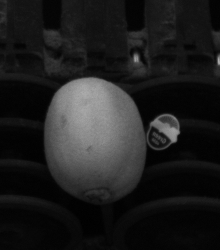 | 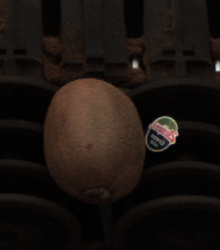 |

It is required to localize eventual defects on the fruits.

*Note: special care should be taken to remove as "background" the dirt on the conveyor as well as the sticker in image `C1_000006`.*

#### Procedure
Although this is an academic project, the working pipeline has been developed considering an industrial setting where the inspection of the fruits has to be carried out by an *online* system. A set of methods have been tested in terms of quality, speed and robustness.

# 00 Prerequisites
The libraries necessary for the task are imported.

In [1]:
%matplotlib inline

import cv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np
import sys
from time import time
import os

from execute_final_challenge import analyze_fruit

# Utils libraries
from utils.edge import *
from utils.colour import *
from utils.colour_threshold import *
from utils.threshold import *
from utils.general import *

The cell below illustrates the version of `OpenCV` used for the task.

In [2]:
print(f'Using OpenCV version: {cv.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [3]:
SEED = 42

cv.setRNGSeed(SEED)
np.random.seed(SEED)

# 01 Image analysis 
The series of images is firstly imported and plotted.

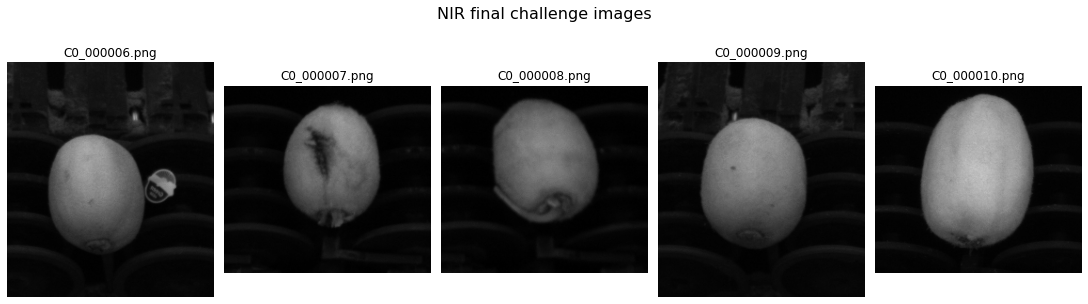

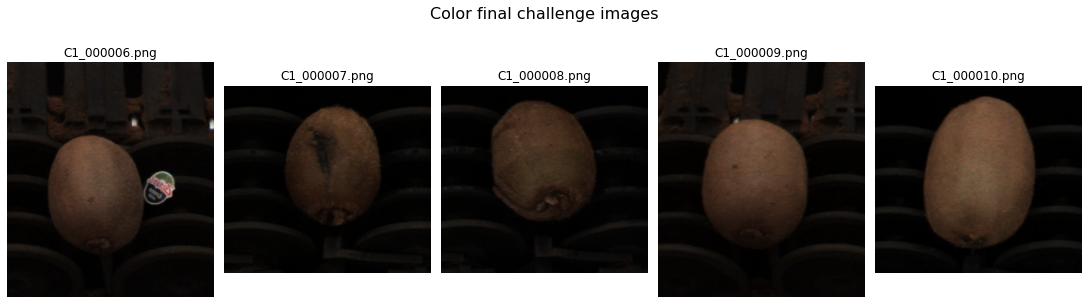

In [4]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_{str(i).zfill(6)}.png' for i in range(6,11)] for j in [0,1]]

# Directory where the images are saved
DIR = '../images/final challenge/'

# Import NIR and color images
nir_imgs = [cv.imread(f'{DIR}{img}', cv.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, nir_names, 'NIR final challenge images')
plot_image_grid(colour_imgs, colour_names, 'Color final challenge images')

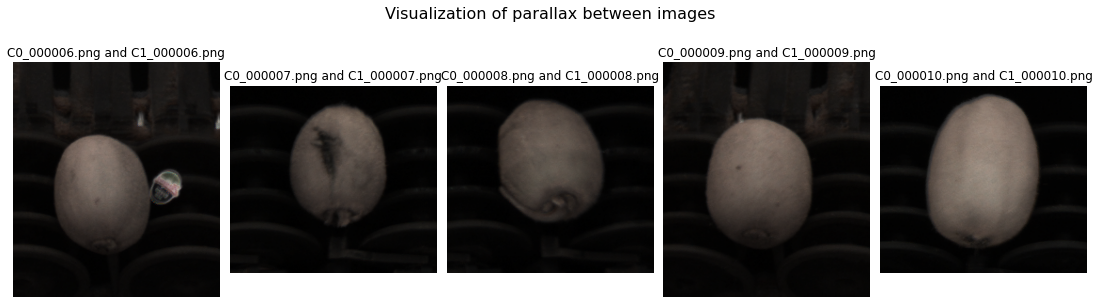

In [5]:
parallaxes = [cv.addWeighted(cv.cvtColor(n, cv.COLOR_GRAY2BGR), 0.5, c, 0.5, 0) 
              for n, c in zip(nir_imgs, colour_imgs)]

plot_image_grid(parallaxes, [f'{n} and {c}' for n, c in zip(nir_names, colour_names)], 
                'Visualization of parallax between images')

Then, the parallax between images is observed. The NIR and colour images seem to overlap almost perfectly, therefore the NIR version of the images can be used to obtain the binary masks of the fruit which can be applied even on their colour version.

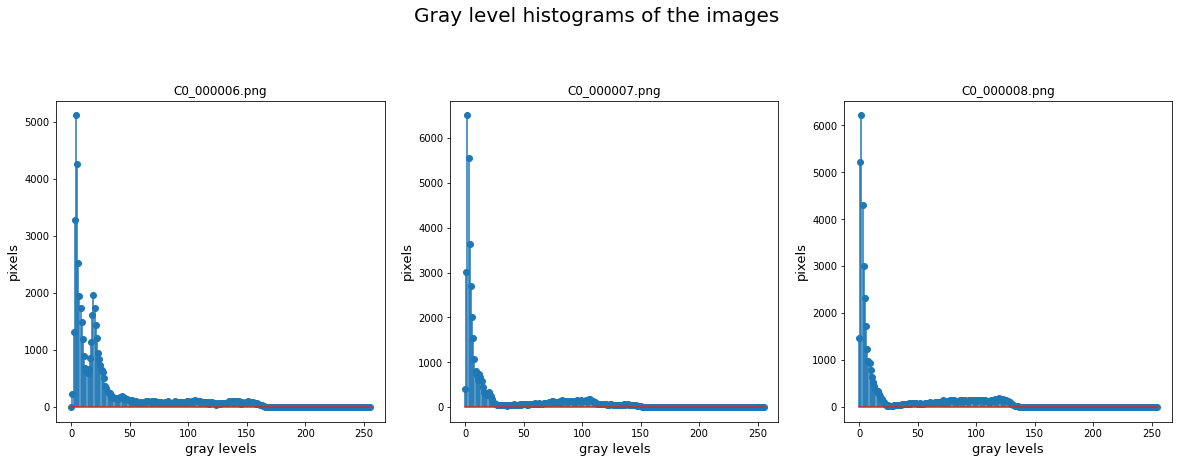

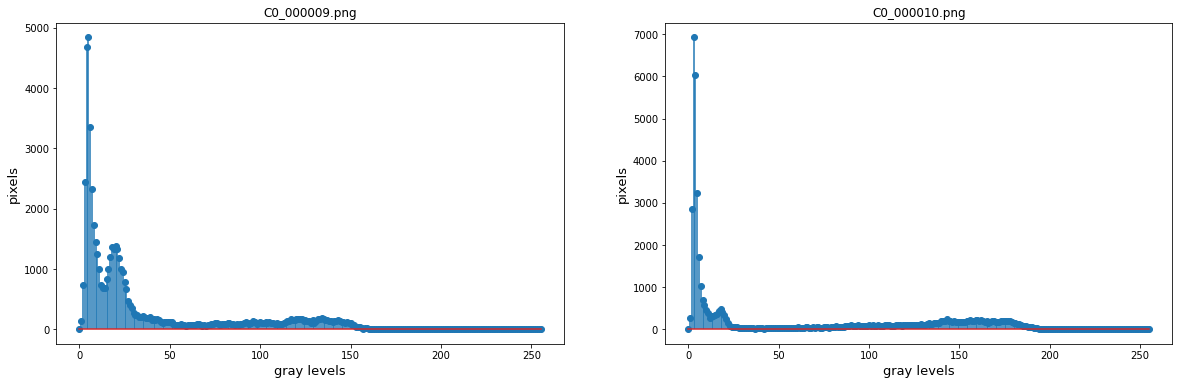

In [6]:
plot_histogram_grid(nir_imgs[:3], nir_names[:3], 'Gray level histograms of the images')
plot_histogram_grid(nir_imgs[3:], nir_names[3:], '')

The *gray-level histograms* of the grayscale images are computed and illustrated. 
From the histograms it can be seen that grey levels are not *bimodal*. In 0-50 range there is a peak in number of pixel and the threshold to perform binarization can be identified. 
Levels in the histograms are *not constant* in that range of value due to the presence of conveyors in the background.

## 02 Pre-processing
As mentioned in *First Task*, in order to guarantee better performances during the binarization tasks a pre-processing operation has been applied to the NIR images.

## 02.1 Median Blur Filtering

In particular, the image have not a smooth background due to the presence of conveyors. 
In order to reduce the background presence of conveyors and obtain a more detailed binarization and outlining of the fruits, a *Median blur* non-linear filter using a kernel of dimension $(7 \times 7)$ has been applied. Thanks to that filter the details of the image will be deleted and the edges will be preserved during the operation

The results are in line with the observation above, as the images are denoised while the edges are preserved and the artifacts on the background are partially removed.

In [7]:
filtered_nir_images = [cv.medianBlur(img, 7) for img in nir_imgs]

As previously observed in First Task, *Otsu's Algorithm* is fast at computing a global threshold $t$ which is different for each image and by applying a simple algorithm to decrease or increase the obtained threshold a good segmentation of fruits can be obtained.

$$t = \texttt{otsu}(I)$$
$$t' = t \cdot \text{tweak factor}$$

For the task, a *tweak factor* of value $0.4$ has been chosen. 
The results obtained through this approach are good as for each image the whole fruit is almost fully segmented from the background in its entirety. 

However, in some images (specially in *C0_000006.png* and *C0_000009.png*) the masks are not well defined due to the presence in the backgroud of the conveyors. 

Another pre-processing technique has to be taken in consideration. 

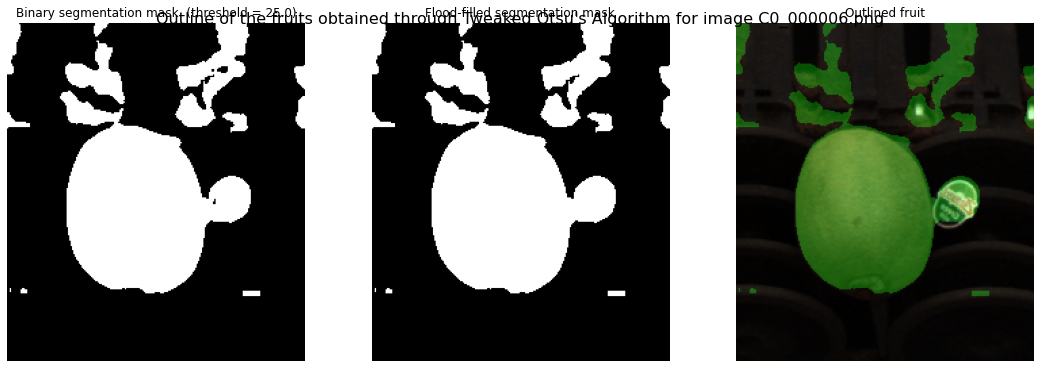

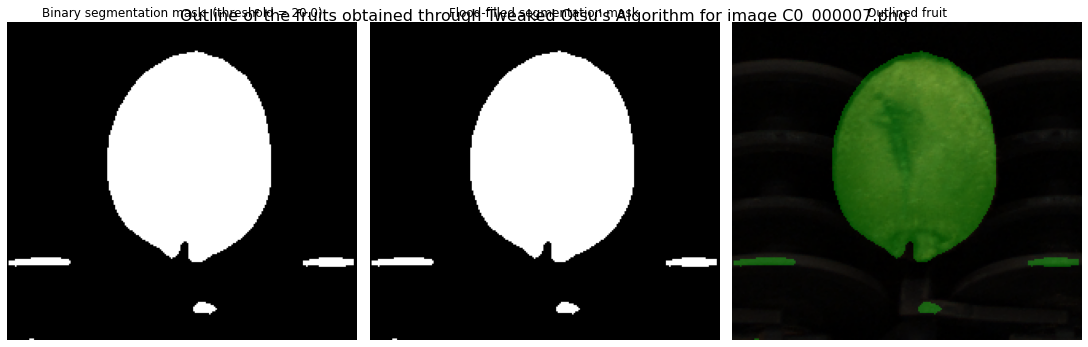

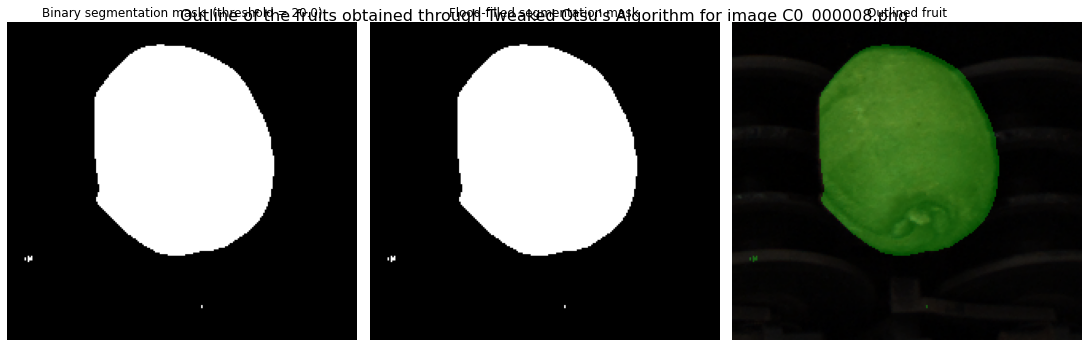

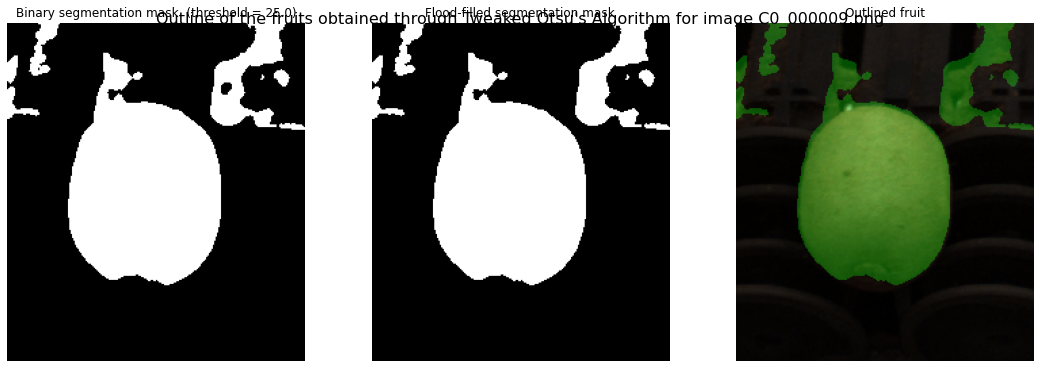

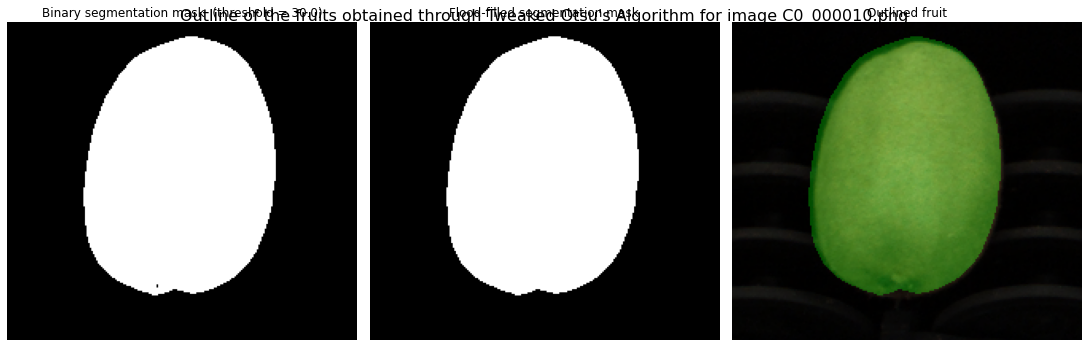

In [8]:
TWEAK_FACTOR = .4

plot_segmentation_process(filtered_nir_images, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

## 02.2 Non-Local Means Filtering
As previous preprocessing method (Median blur) is not effective at segmenting the fruits and separating the background, a *Non-local means* denoising filter is applied to the images.

Non-local means filtering takes a mean of all pixels in the image and preserves the edges, while removing noise from the orinal image. The similarities among patches spread over the image can be deployed to achieve denosising. The usage of the filter with a high strength will perfectly remove noise but also removes image details in the background. 

A comparison of different preprocessing filters is shown.

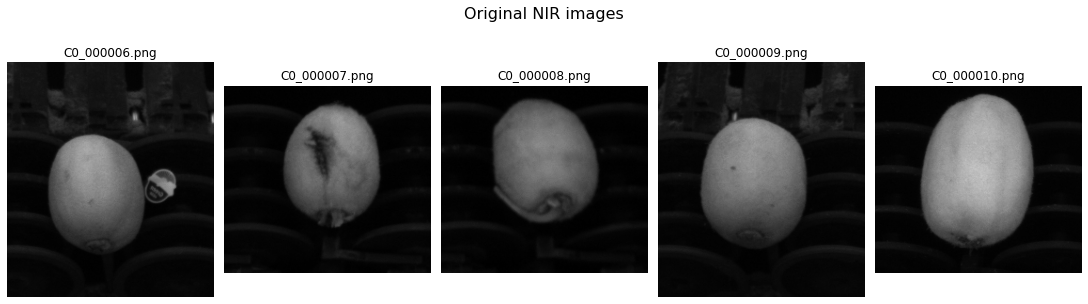

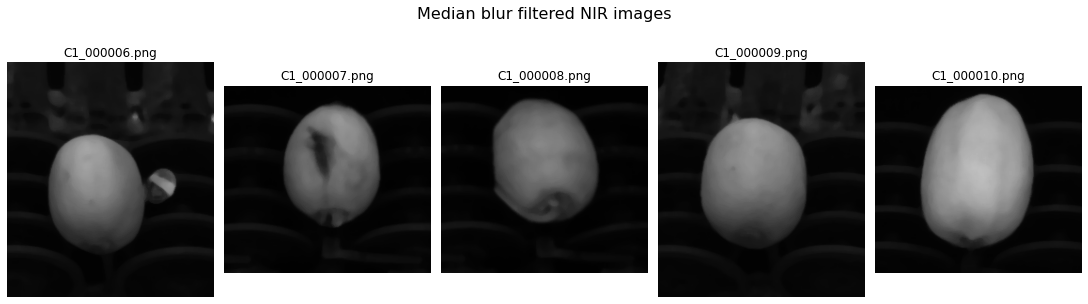

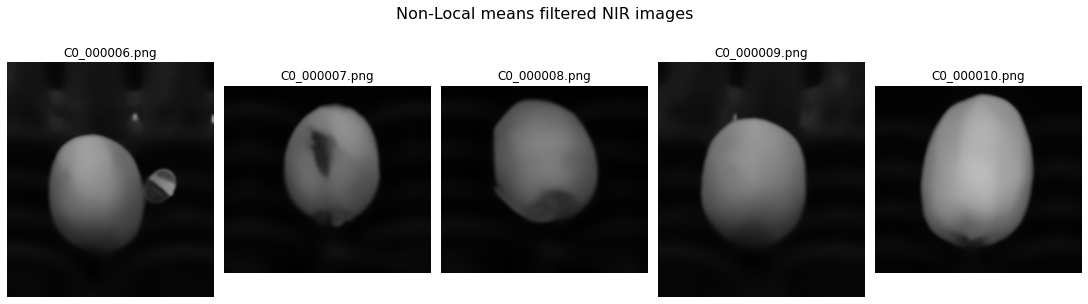

In [9]:
nl_filtered_imgs = [cv.fastNlMeansDenoising(img, h=25) for img in nir_imgs]
plot_image_grid(nir_imgs, nir_names, 'Original NIR images')
plot_image_grid(filtered_nir_images, colour_names, 'Median blur filtered NIR images')
plot_image_grid(nl_filtered_imgs, nir_names, 'Non-Local means filtered NIR images')

The results obtained through this approach are better as for each image the whole fruit is almost fully segmented and the conveyor noise is less marked in the masks of *C0_000006.png* and *C0_000009.png* images.

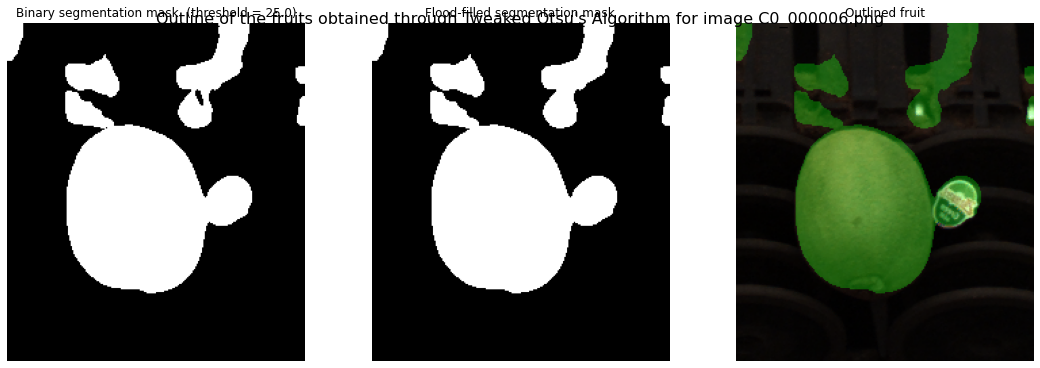

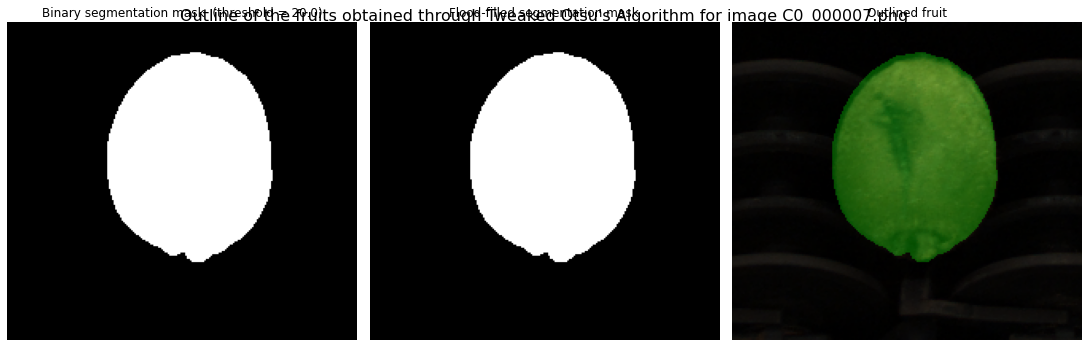

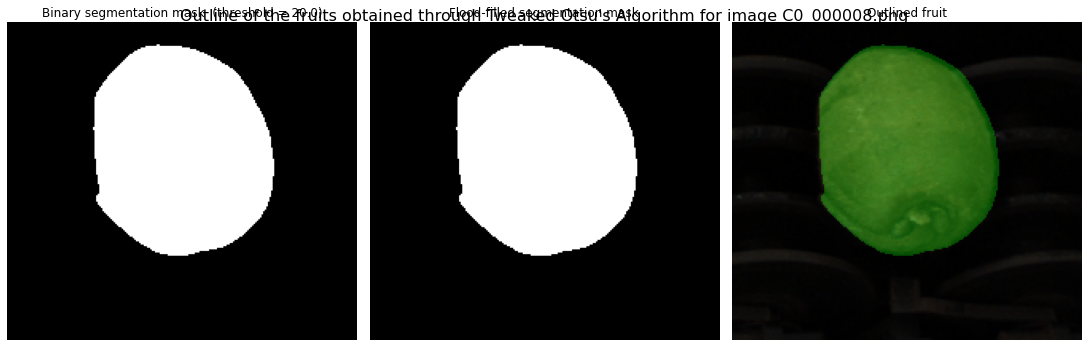

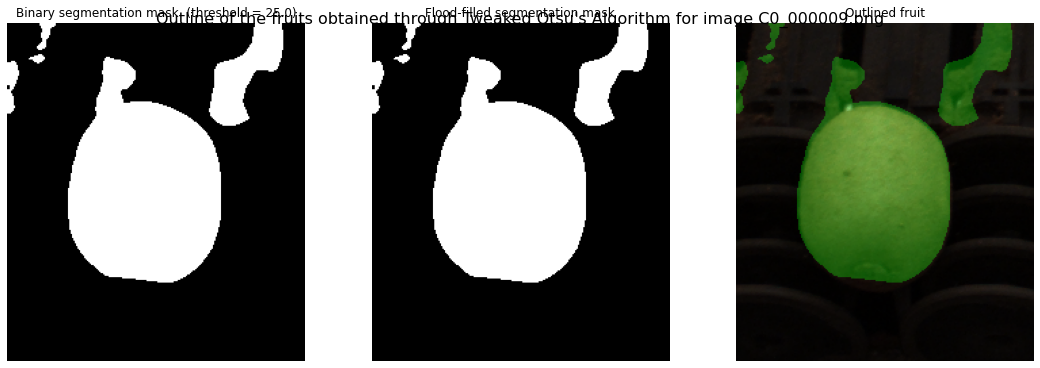

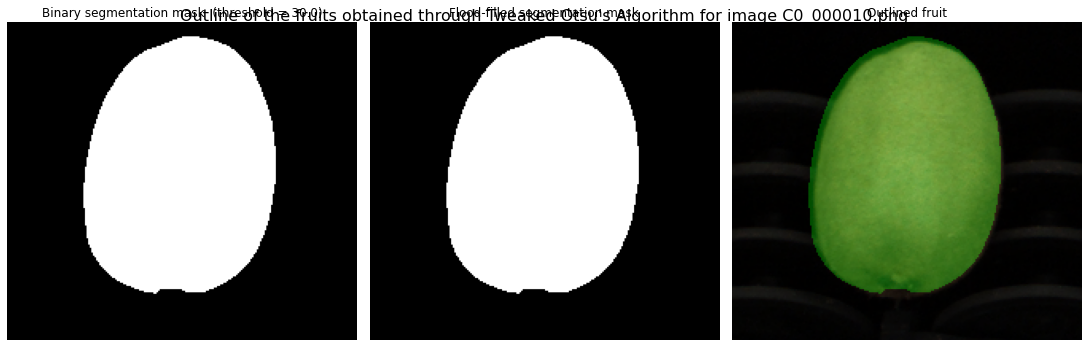

In [10]:
TWEAK_FACTOR = .4
plot_segmentation_process(nl_filtered_imgs, colour_imgs, nir_names, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR)

However, comparing time taken to pre-process the image is very different by comparing different methods. Non-local denoising takes almost x10 time to apply the filter. 

The second algorithm is slow and still not completely removing the conveyors noise, so it is not taken in consideration for the task.

In [11]:
s = time()
for img in nir_imgs * 100:
    cv.medianBlur(img,7)
median_time = time() - s

s = time()
for img in nir_imgs * 100:
    cv.fastNlMeansDenoising(img, h=25)
nl_denoising_time = time() - s

In [12]:
print(f'Time for preprocessing {100 * len(colour_imgs)} images with a median filter: {median_time:.6f}')
print(f'Mean time for preprocessing an image with a median filter: {(median_time / (100 * len(colour_imgs))):.6f}')
print()

print(f'Time for preprocessing {100 * len(colour_imgs)} images with a non-local mean filter: {nl_denoising_time:.6f}')
print(f'Mean time for preprocessing an image with a non-local mean filter: {(nl_denoising_time / (100 * len(colour_imgs))):.6f}')

Time for preprocessing 500 images with a median filter: 0.703417
Mean time for preprocessing an image with a median filter: 0.001407

Time for preprocessing 500 images with a non-local mean filter: 48.051717
Mean time for preprocessing an image with a non-local mean filter: 0.096103


## 03 Segmentation
The masks obtained through binarization are applied over the Near Infra-Red images, the Near Infra-Red images pre-processed by *Median Blur* and the colour images and the results are plotted. 

In [13]:
TWEAK_FACTOR = .4
masks = [get_fruit_segmentation_mask(img, ThresholdingMethod.TWEAKED_OTSU, tweak_factor=TWEAK_FACTOR) for img in filtered_nir_images]

Masks obtained throught segmentation still have some blobs that should be removed. 

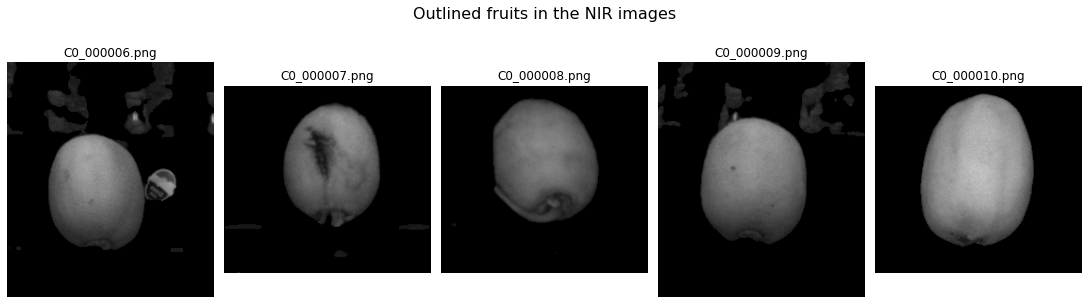

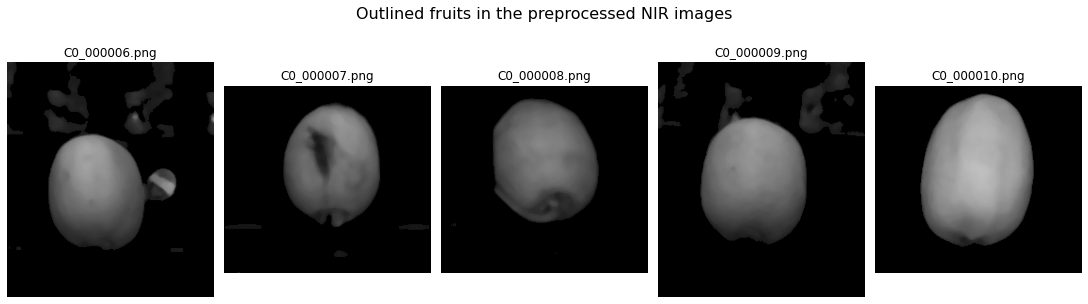

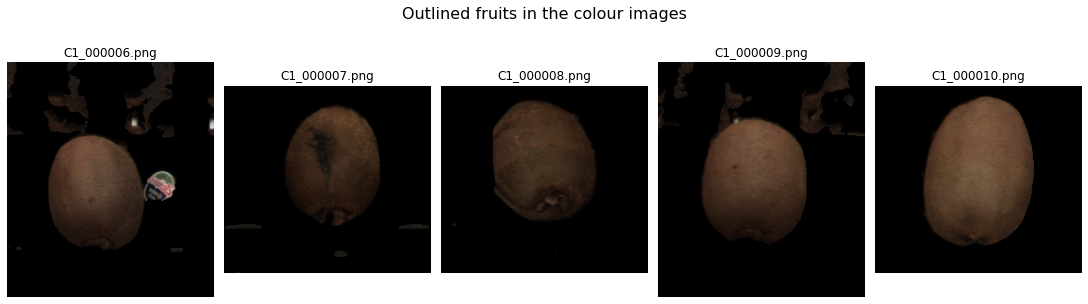

In [14]:
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
masked_filtered_imgs = [filtered_nir_images[i] & masks[i] for i in range(len(masks))]
masked_colour_imgs = [colour_imgs[i] &  cv.cvtColor(masks[i], cv.COLOR_GRAY2BGR) for i in range(len(masks))]

plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_filtered_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')
plot_image_grid(masked_colour_imgs, colour_names, 'Outlined fruits in the colour images')

## 03.1 Artefacts Elimination

In order to clean the mask two different openings are performed. An opening is an erosion followed by dilation and it is useful in removing noise.

Opening operations are performed using two different structuring elements:
- 1st ELLIPSE opening with shape *(20, 5)*, used to remove background noise from horizontal parts of the fruits
- 2nd ELLIPSE opening with shape *(5, 20)*, used to remove background noise from vertical parts of the fruits

Opening garantuee the fruit to be detached from background noise. After that, fruits masks can be identified by identifying the biggest blob.

In [15]:
s = time()
for i in range(100):
    se1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,5))
    se2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,20))
    masks_opening_1 = [cv.morphologyEx(m, cv.MORPH_OPEN, se1) for m in masks]
    masks_opening_2 = [cv.morphologyEx(m, cv.MORPH_OPEN, se2) for m in masks_opening_1]
    masked_nir_imgs1 = [nir_imgs[i] & masks_opening_2[i] for i in range(len(masks))]
total_time = time() - s

print(f'Total time to perform Opening over {100} images: {total_time}')
print(f'Mean time per image: {total_time / (len(nir_imgs) *100)}')

Total time to perform Opening over 100 images: 0.5401768684387207
Mean time per image: 0.0010803537368774415


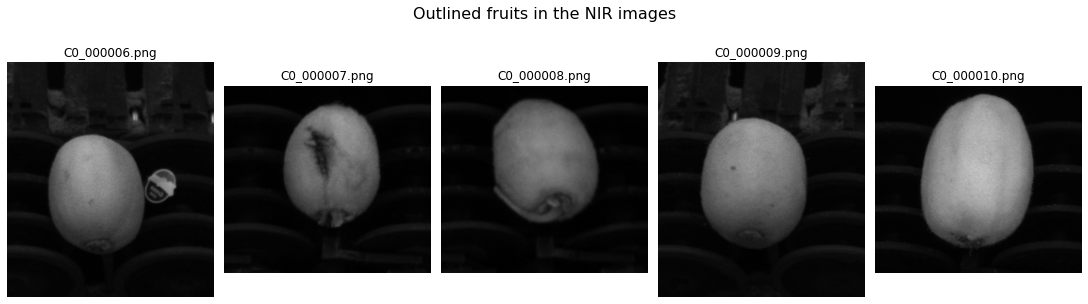

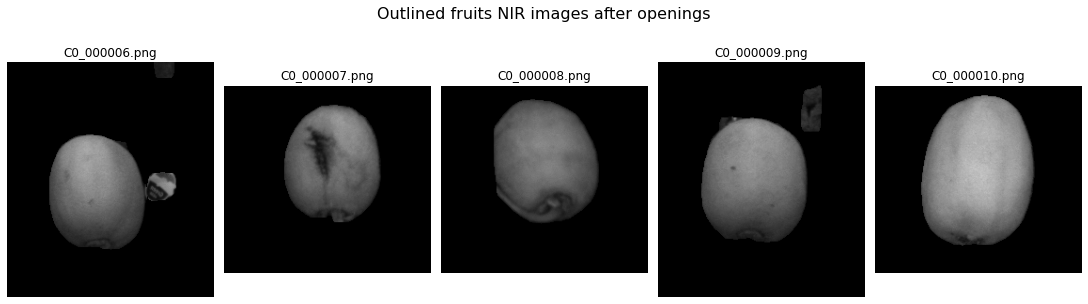

In [16]:
se1 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,5))
se2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,20))
masks = [cv.morphologyEx(m, cv.MORPH_OPEN, se1) for m in masks]
masks = [cv.morphologyEx(m, cv.MORPH_OPEN, se2) for m in masks]
masked_nir_imgs = [nir_imgs[i] & masks[i] for i in range(len(masks))]
plot_image_grid(nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits NIR images after openings')

In [17]:
masks = [get_largest_blob_in_mask(m) for m in masks]

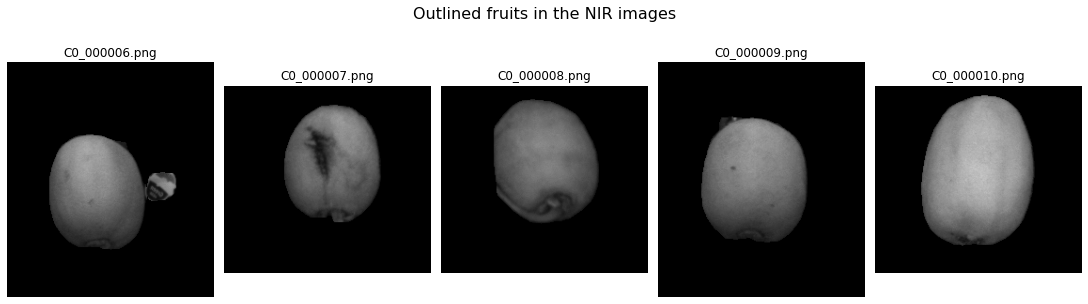

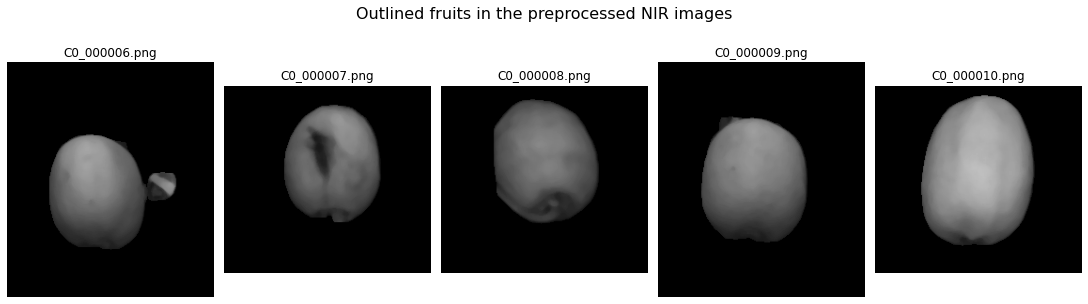

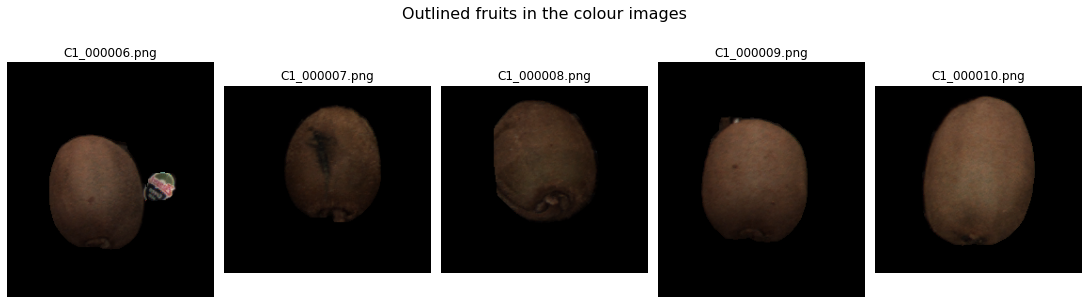

In [18]:
masked_nir_imgs = [apply_mask_to_image(img, m) for img, m in zip(nir_imgs, masks)]
masked_filtered_imgs = [apply_mask_to_image(img, m) for img, m in zip(filtered_nir_images, masks)]
masked_colour_imgs = [apply_mask_to_image(img, m) for img, m in zip(colour_imgs, masks)]

plot_image_grid(masked_nir_imgs, nir_names, 'Outlined fruits in the NIR images')
plot_image_grid(masked_filtered_imgs, nir_names, 'Outlined fruits in the preprocessed NIR images')
plot_image_grid(masked_colour_imgs, colour_names, 'Outlined fruits in the colour images')

## 03.2 Sticker Removal
The masks obtained through segmentation of image *000006* still contains the sticker. The segmentation of the fruits is performed based on the colour of the fruit.

A three-dimensional plot of the colour distribution of the pixels of each image in each colour space is illustrated.

The resulting plots highlight that the colour distribution of the *kiwi area* and the one of the *sticker area* are pretty different. It can be easily identified the kiwi using colour distance and remove artifacts like the stickers considering their distance from the a reference kiwi area.

A colour reference is extracted from kiwi samples and colour segmentation by considering the *Mahalanobis distance* from the refencense is performed.

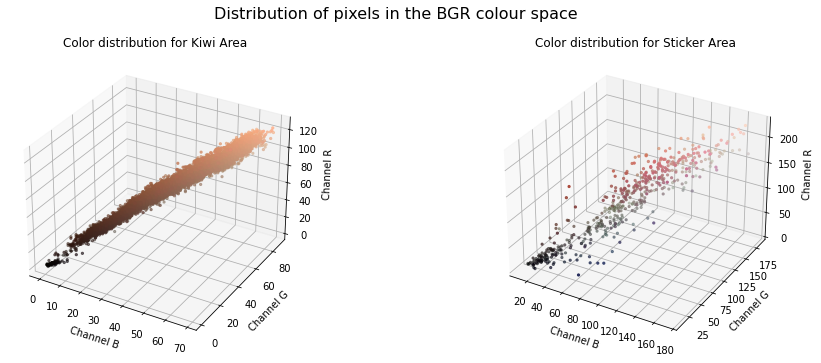

In [19]:
rgb_colour_space = ColourSpace('BGR')

sticker_area = colour_imgs[0][125:145, 150:175]
kiwi_area = colour_imgs[0][100:190, 50:130]


plot_colour_distribution_3d([kiwi_area, sticker_area], ['Kiwi Area', 'Sticker Area'], rgb_colour_space)

In [20]:
filtered_masked_colour_imgs = [cv.medianBlur(img,5) for img in masked_colour_imgs]

The colour reference can be computed accurately by obtaining the *mean* ($\mu$) and the *inverse covariance matrix* ($\Sigma^{-1}$) of a series of training samples. 

The training samples have been chosen as patches of the *ROI* and not as single pixels for robustness reasons. The final *mean* and *covariance matrix*. As in Second Task, the final *mean* and *covariance matrix* of the colour reference are obtained by each sample. 

Once the distance of each pixels from the reference colour is obtained and collected in a resulting image $I$, just the ones with a distance less or equal than a certain threshold $t$ can be classified as part of the *ROI*, while the others can be discarded. The pixels that are part of the sticker are then not considered because their distance from *ROI* is higher than threshold.


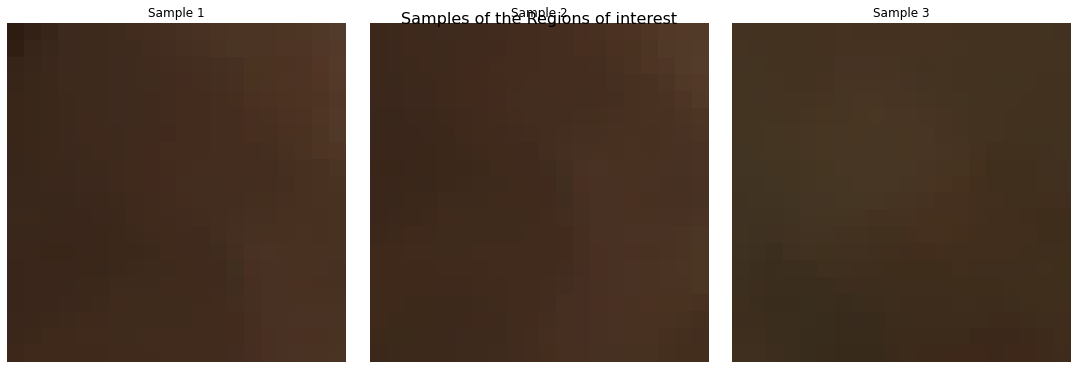

In [21]:
NUM_PATCHES = 200
PATCH_SIZE = 20

samples = get_roi_samples(filtered_masked_colour_imgs[2], NUM_PATCHES, PATCH_SIZE)
samples += get_roi_samples(filtered_masked_colour_imgs[4], NUM_PATCHES, PATCH_SIZE)

plot_image_grid([samples[0], samples[PATCH_SIZE], samples[PATCH_SIZE*2]], 
                [f'Sample {i}' for i in range(1,4)],
                'Samples of the Regions of interest')

**LAB** colourspace is considered the space that yield the best results in previous task so it is considered and the sampkles are transformed to compute the colour references.

In [22]:
lab_colour_space = ColourSpace('LAB')

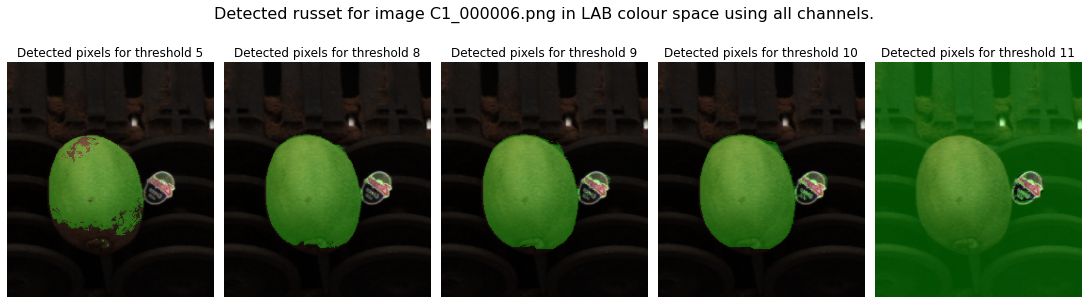

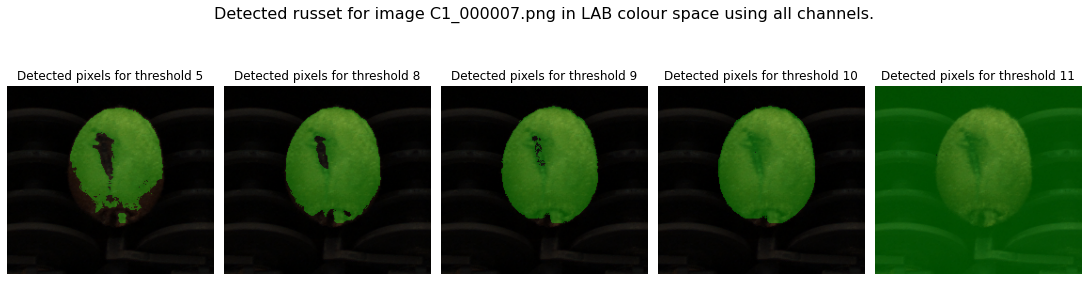

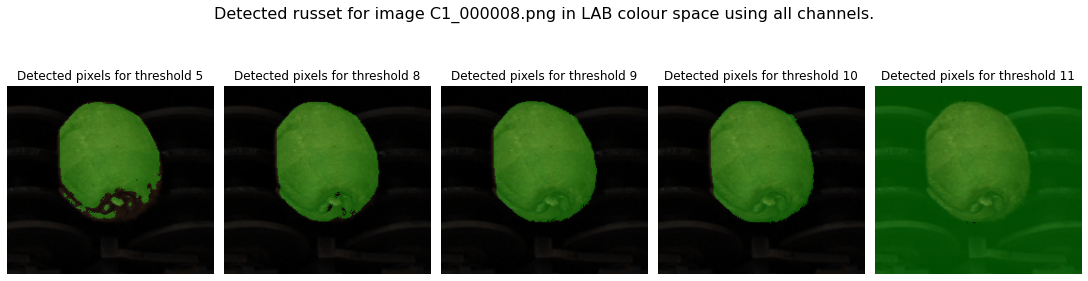

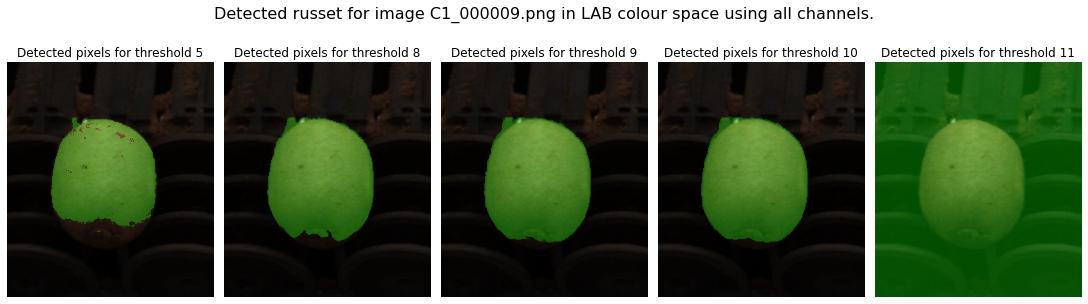

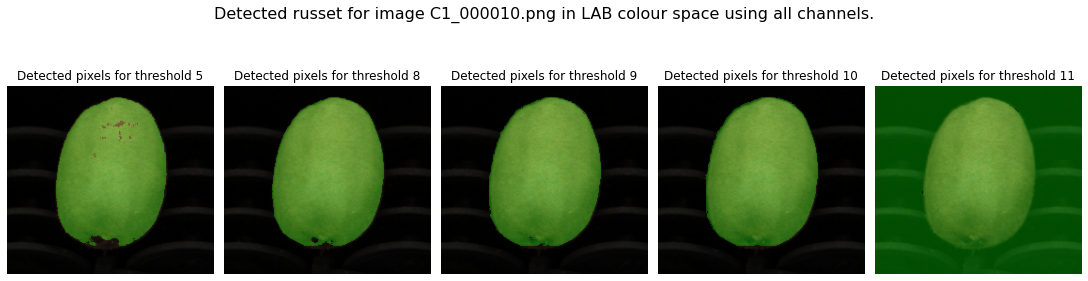

In [23]:
thresholds = [5, 8, 9, 10, 11]
mean, inv_cov = get_mean_and_inverse_covariance_matrix(samples, lab_colour_space, channels=(1, 2))
for idx, img in enumerate(filtered_masked_colour_imgs):
    plot_mahalanobis_segmentation_comparisons(lab_colour_space.bgr_to_colour_space(img), colour_imgs[idx], mean, inv_cov, thresholds, 
                             f'Detected russet for image {colour_names[idx]} in LAB colour space using all channels.', 
                             channels=(1, 2))

The means and covariance matrices are saved in memory for future usages.

In [24]:
DATA_DIR = './data'
data_dir = os.makedirs(DATA_DIR, exist_ok=True)

np.save(f'{DATA_DIR}/mean_final_challenge', mean)
np.save(f'{DATA_DIR}/inv_cov_final_challenge', inv_cov)

With a threshold of value $10$, almost all of pixels of the fruits are obtained with a few false positives that can be removed by cleaning the masks. 

The sticker is not considered as part of *ROI*.

In [25]:
lab_imgs = [lab_colour_space.bgr_to_colour_space(img) for img in filtered_masked_colour_imgs]
masks = [get_mahalanobis_distance_segmented_image(img, mean, inv_cov, 10, (1, 2)) for img in lab_imgs]

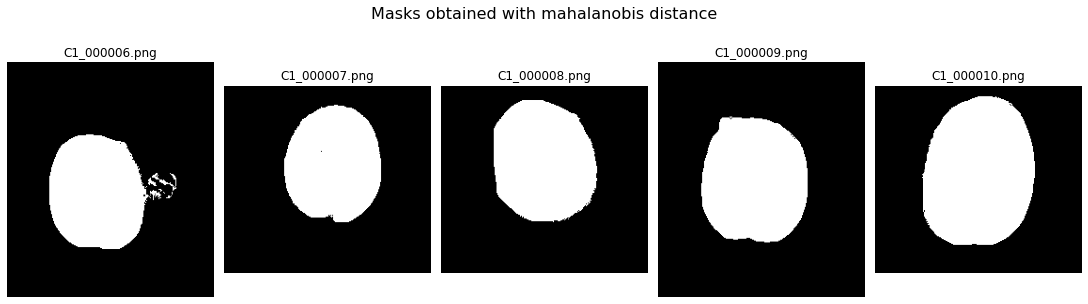

In [26]:
plot_image_grid(masks, colour_names, 'Masks obtained with mahalanobis distance')

An opening followed by a closing is performed in order to clean the masks and make the shapes smoother.

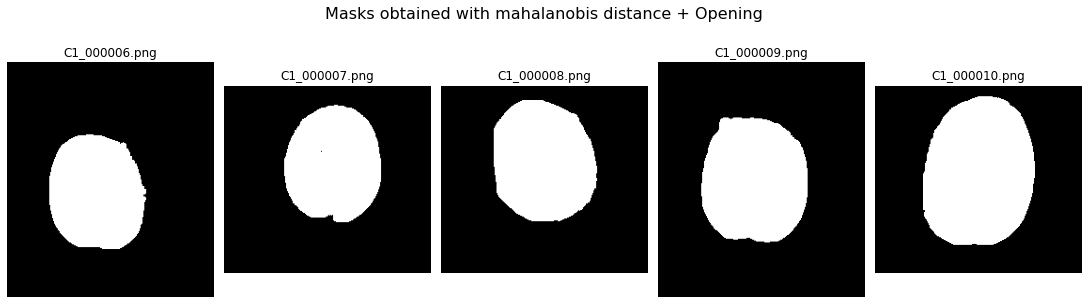

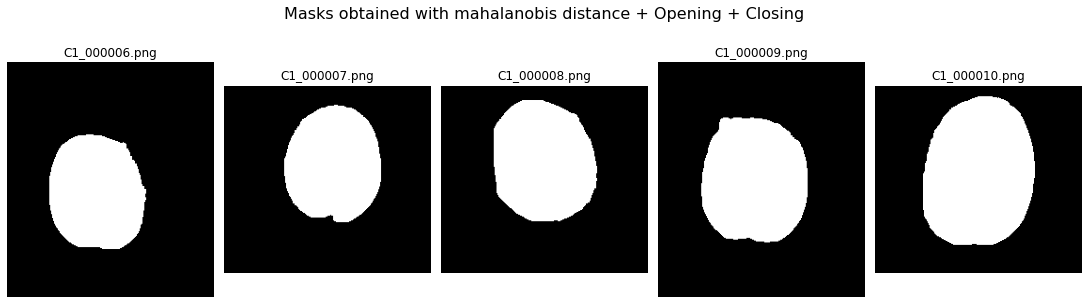

In [27]:
se = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
masks = [cv.morphologyEx(m, cv.MORPH_OPEN, se) for m in masks]
plot_image_grid(masks, colour_names, 'Masks obtained with mahalanobis distance + Opening')
masks = [cv.morphologyEx(m, cv.MORPH_CLOSE, se) for m in masks]
plot_image_grid(masks, colour_names, 'Masks obtained with mahalanobis distance + Opening + Closing')

In [28]:
masked_nir_imgs = [apply_mask_to_image(img, m) for img, m in zip(filtered_nir_images, masks)]

## 04 Edge extraction
n order to extract the edges, *Canny's method* is applied to the filtered and masked Near Infra-Red images.

*Canny's method* implementation in `OpenCV` does not perform the initial *Gaussian Smoothing*, therefore it was manually applied with a value of $\sigma$ = 1 and a kernel size computed by a rule-of-thumb:
$$k = \left\lceil 3 \cdot \sigma \right\rceil$$
$$\text{kernel size} = (2 \cdot k + 1 \times 2 \cdot k + 1)$$

Regarding the *hysteresis* thresholds, the best results have been obtained with $t_h = 85$ and $t_l = 50$. 

Below plots of the obtained edge masks for each fruit are shown.

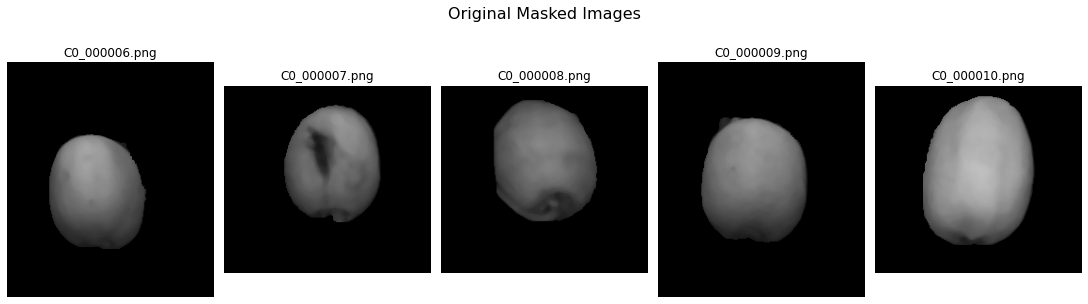

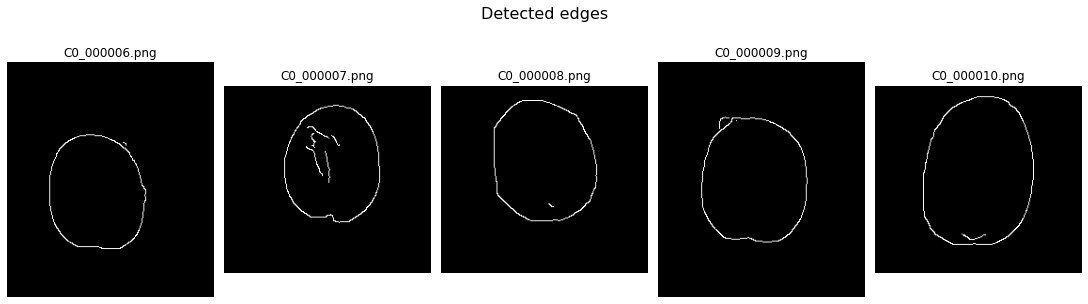

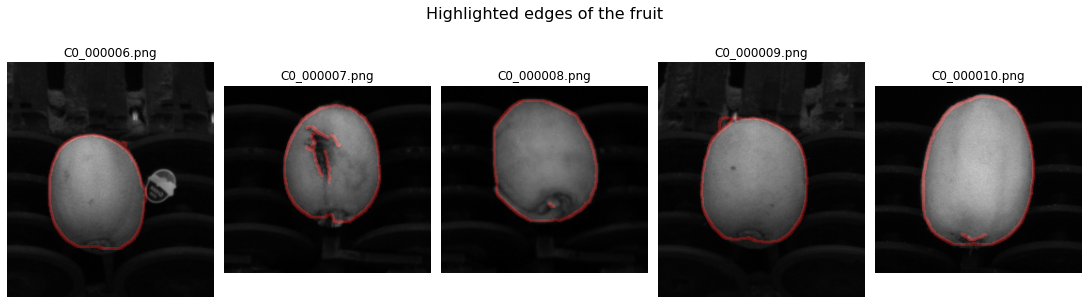

In [29]:
SIGMA = 1
THRESHOLD_1 = 50
THRESHOLD_2 = 85

edge_masks = [apply_gaussian_blur_and_canny(img, SIGMA, THRESHOLD_1, THRESHOLD_2) for img in masked_nir_imgs]
highlighted_edges_images = [get_highlighted_edges_on_image(img, e) for img, e in zip(nir_imgs, edge_masks)]

plot_image_grid(masked_nir_imgs, nir_names, 'Original Masked Images')
plot_image_grid(edge_masks, nir_names, 'Detected edges')
plot_image_grid(highlighted_edges_images, nir_names, 'Highlighted edges of the fruit')

To remove the edges along the border of the fruit the binary mask has been eroded by a rectangular *structuring element* of size $15 \times 15$ and it was applied over the edge mask.

Thanks to this operation, solely the edges of the defects, along with some noisy artifacts, are preserved.

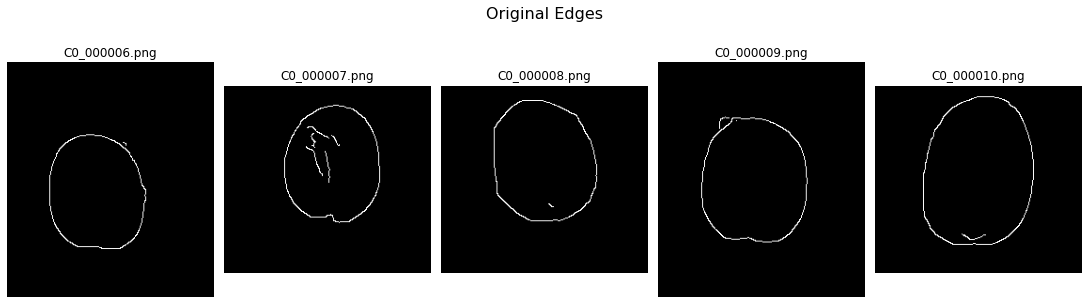

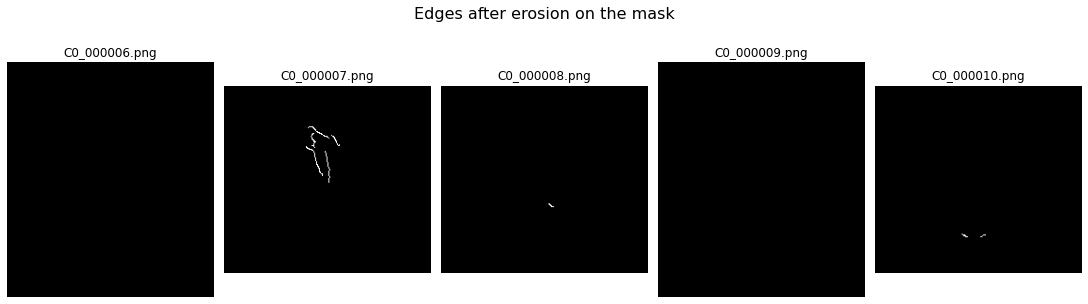

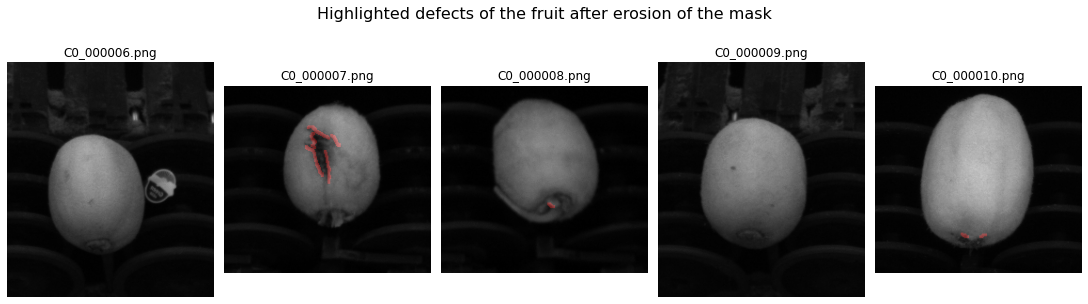

In [30]:
element = cv.getStructuringElement(cv.MORPH_RECT, (15, 15))
eroded_masks = [cv.erode(img, element) for img in masks]
eroded_edge_masks = [edge_masks[i] &  eroded_masks[i] for i in range(len(masks))]
highlighted_edges_images = [get_highlighted_edges_on_image(img, e) for img, e in zip(nir_imgs, eroded_edge_masks)]

plot_image_grid(edge_masks, nir_names, 'Original Edges')
plot_image_grid(eroded_edge_masks, nir_names, 'Edges after erosion on the mask')
plot_image_grid(highlighted_edges_images, nir_names, 'Highlighted defects of the fruit after erosion of the mask')

## 04.2 Defect edge filling
In order to fill the edges of the defects in the edge mask and obtain a blob in correspondence of each defect, a *Closing* operation with a circular structuring element of size $50 \times 50$ was applied.

The results are shown below. As it can be observed, the blobs in correspondence of the defects are obtained even if some noisy artifacts remain.

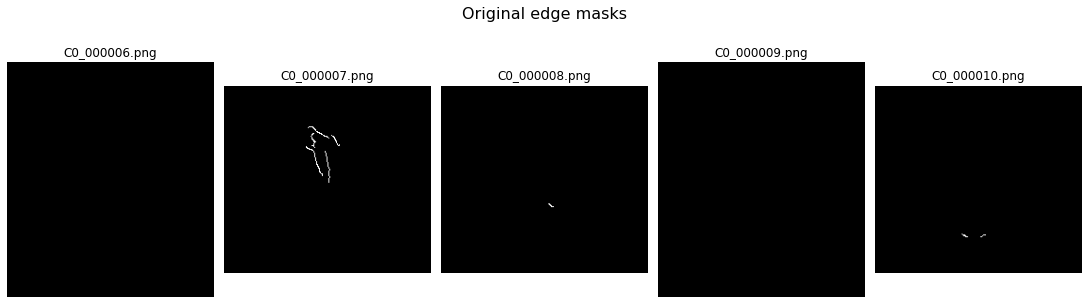

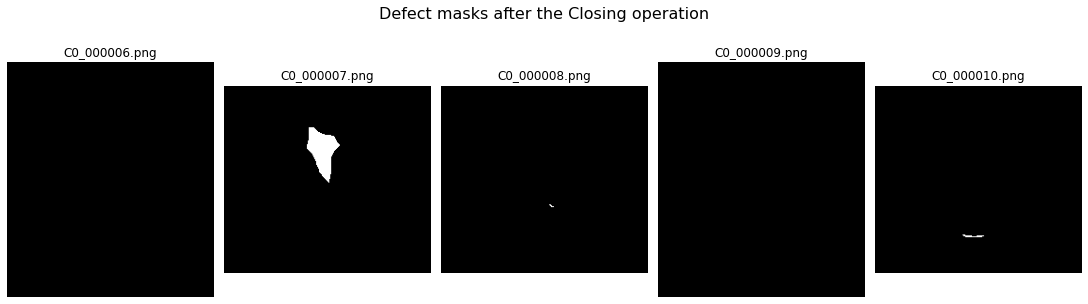

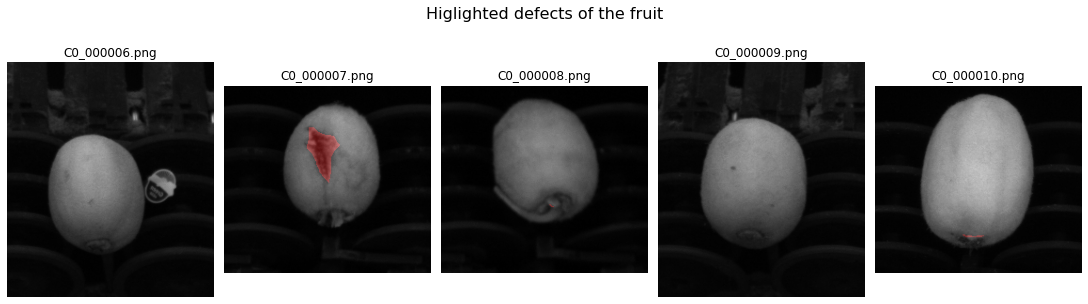

In [31]:
element = cv.getStructuringElement(cv.MORPH_ELLIPSE, (50, 50))
defect_masks = [cv.morphologyEx(img, cv.MORPH_CLOSE, element) for img in eroded_edge_masks]
highlighted_defects = [get_highlighted_roi_by_mask(img, e, 'red') for img, e in zip(nir_imgs, defect_masks)]

plot_image_grid(eroded_edge_masks, nir_names, 'Original edge masks')
plot_image_grid(defect_masks, nir_names, 'Defect masks after the Closing operation')
plot_image_grid(highlighted_defects, nir_names, 'Higlighted defects of the fruit')

To remove the noisy artifacts a *Median Blur* of kernel $7 \times 7$ is performed. The idea behind this operation is that small artefacts can be considered as some kind of *impulse noise*. Hence, a median filter is able to remove them while preserving the structure of the blobs in correspondence of the defects.

The final cleaned-up edge mask can be seen below.

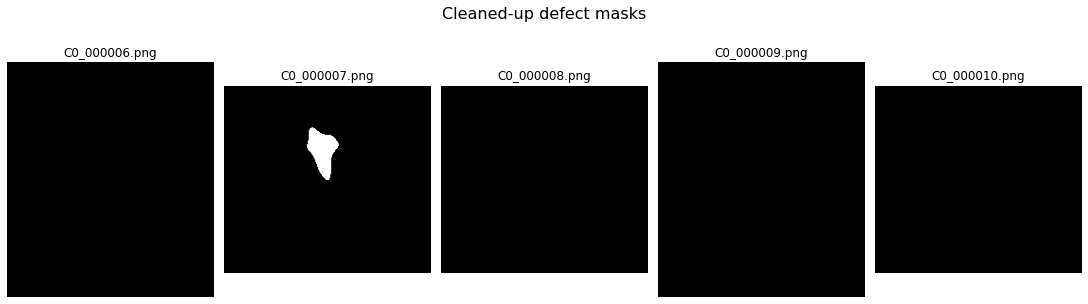

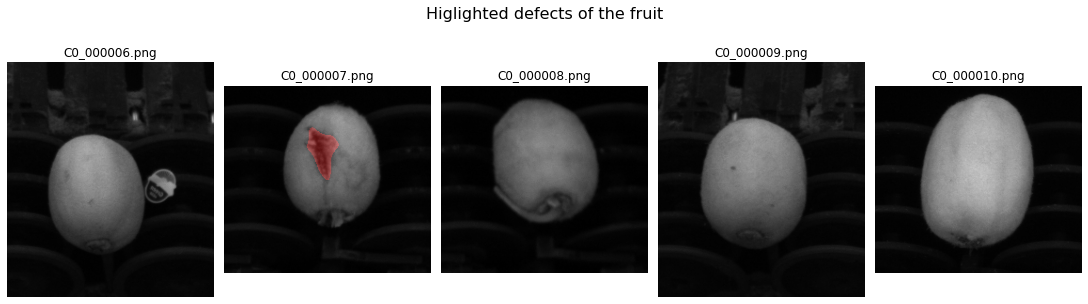

In [32]:
defect_masks = [cv.medianBlur(m, 7) for m in defect_masks]
highlighted_defects = [get_highlighted_roi_by_mask(img, e, 'red') for img, e in zip(nir_imgs, defect_masks)]

plot_image_grid(defect_masks, nir_names, 'Cleaned-up defect masks')
plot_image_grid(highlighted_defects, nir_names, 'Higlighted defects of the fruit')

## 05 Results
An algorithm performing the steps described above is built in `src/execute_final_challenge.py` and it can be executed via command line or by the method `analyze_fruit`. 

The algorithm:
- Filters the image by *Median Blur* with a kernel $7 \times 7$;
- Applies *Tweaked Otsu's Algorithm* to obtain the segmented fruit;
- Performs two openings through ellipses to clean up the masks
- Applies the mask over the filtered colour image;
- Turns the masked colour image to the LAB colour space;
- Gets a fruit mask by applying colour segmentation with respect to the colour reference of the fruit colour;
- Uses *Canny's Algorithm* by firstly blurring the masked image through *Gaussian Blur* with $\sigma = 1$;
- It obtains the defect blobs by the edge mask and removes the noisy artifacts;
- Shows the blobs of the defects, counts their occurrences and highlights their position through ellipses;
- Returns statistics about the defects.


In [33]:
mean_final_challege = np.load(f'{DATA_DIR}/mean_final_challenge.npy')
inv_cov_final_challege = np.load(f'{DATA_DIR}/inv_cov_final_challenge.npy')

Detected 1 defect for image .


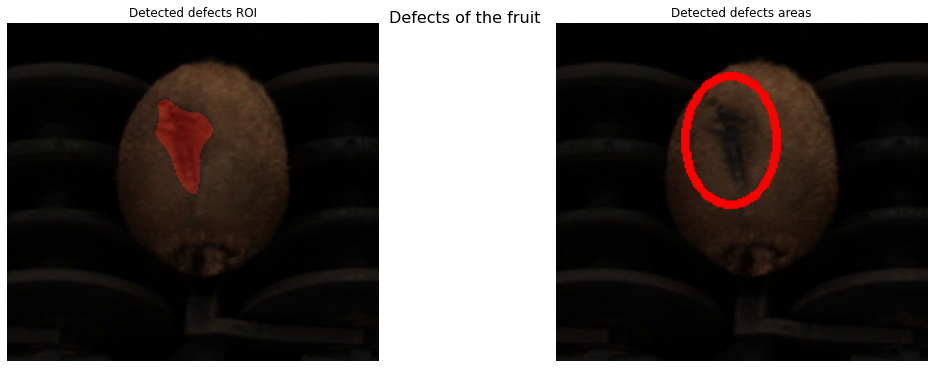

In [34]:
_ = analyze_fruit(colour_imgs[1], nir_imgs[1], tweak_factor=TWEAK_FACTOR, sigma=SIGMA,
                   threshold_1=THRESHOLD_1, threshold_2=THRESHOLD_2, mean=mean_final_challege, inv_cov=inv_cov_final_challege)

In [35]:
s = time()

for col, nir, name in list(zip(colour_imgs, nir_imgs, colour_names)) * 1_000:
    analyze_fruit(col, nir, image_name=name, tweak_factor=TWEAK_FACTOR, sigma=SIGMA,
                   threshold_1=THRESHOLD_1, threshold_2=THRESHOLD_2, mean=mean_final_challege, inv_cov=inv_cov_final_challege, verbose=False)

total_time = time() - s

In [36]:
print(f'Time for analizing {1_000 * len(colour_imgs)} images of fruits: {total_time:.6f}')
print(f'Mean time for analizing an image of a fruit: {(total_time / (1_000 * len(colour_imgs))):.6f}')

Time for analizing 5000 images of fruits: 107.483836
Mean time for analizing an image of a fruit: 0.021497


## 05.1 Portability

Even if The system is designed to work in an environment with a uniform and constant illumination, the segmentation algorithm is a robust method, that should adapt easily to environments with different illumination and still garantees a good result.

The system is easily portable to other industrial settings by simply modifying some of its parameters.
In order to prove so, a version of the colour images and the NIR images with a darker and brighter contrast intensity are computed from the initial images and shown below.

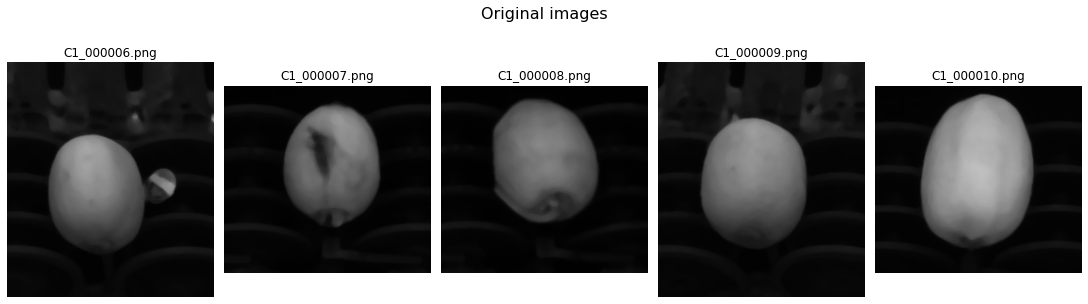

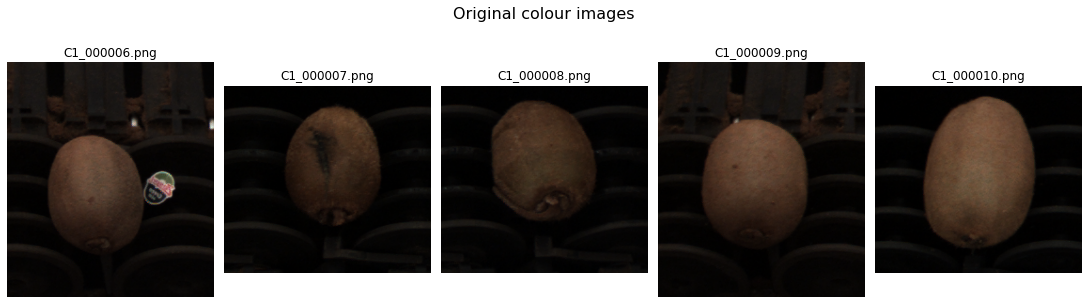

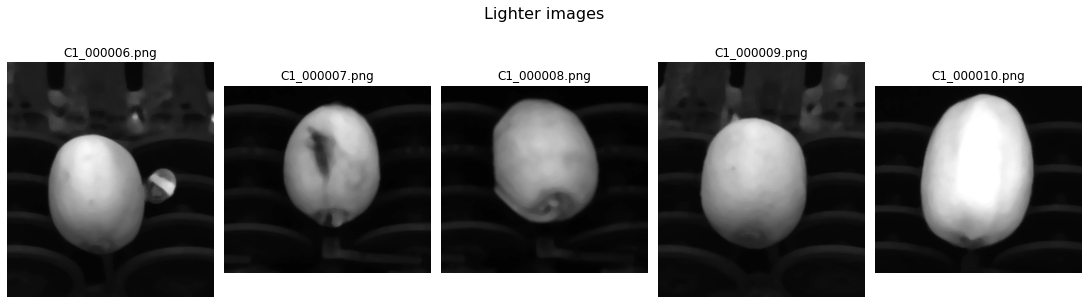

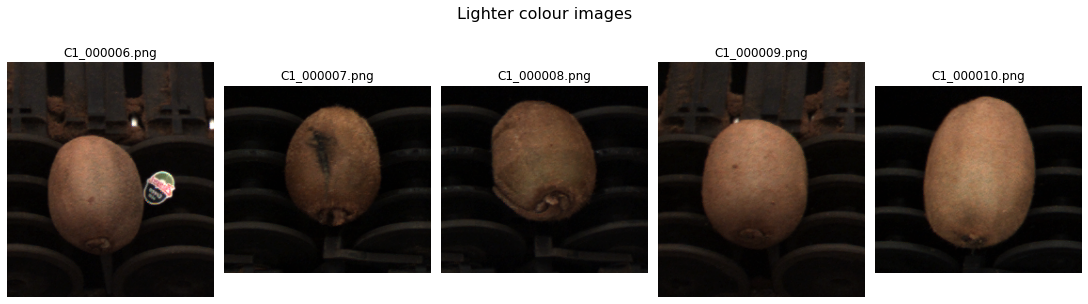

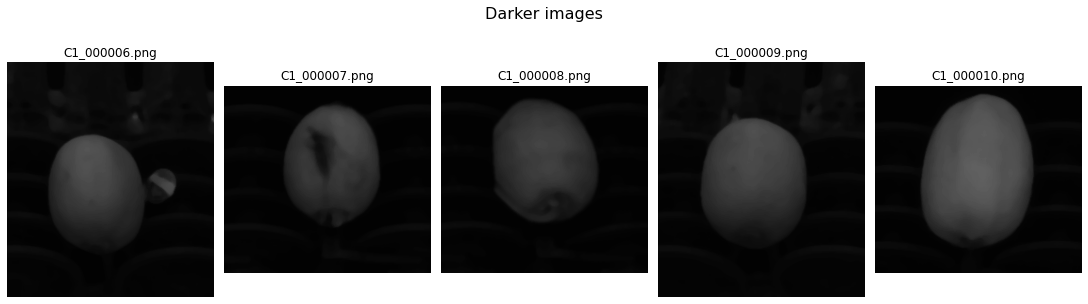

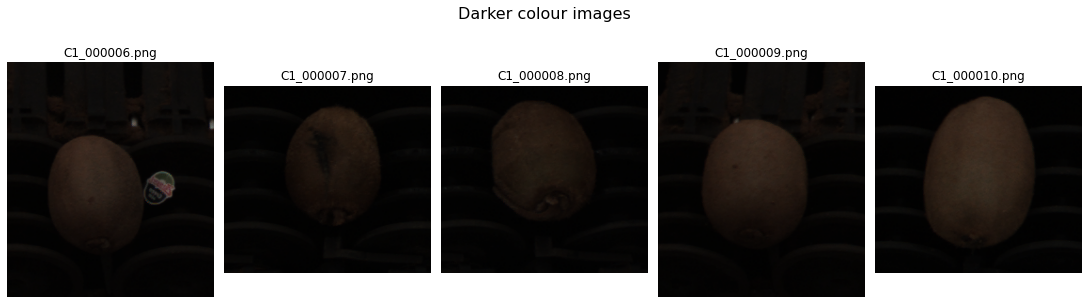

In [49]:
filtered_darker_images = [cv.convertScaleAbs(img, alpha=.5, beta=1) for img in filtered_nir_images]
filtered_lighter_images = [cv.convertScaleAbs(img, alpha=1.5, beta=1) for img in filtered_nir_images]
colour_darker_images = [cv.convertScaleAbs(img, alpha=.5, beta=1) for img in colour_imgs]
colour_lighter_images = [cv.convertScaleAbs(img, alpha=1.5, beta=1) for img in colour_imgs]

plot_image_grid(filtered_nir_images, colour_names, 'Original images')
plot_image_grid(colour_imgs, colour_names, 'Original colour images')

plot_image_grid(filtered_lighter_images, colour_names, 'Lighter images')
plot_image_grid(colour_lighter_images, colour_names, 'Lighter colour images')

plot_image_grid(filtered_darker_images, colour_names, 'Darker images')
plot_image_grid(colour_darker_images, colour_names, 'Darker colour images')

With the same tweak factor and slightly different Canny thresholds ($t_l = 10$ and $t_h = 40$) the defect detection works on darker images.

Detected 1 defect for image .


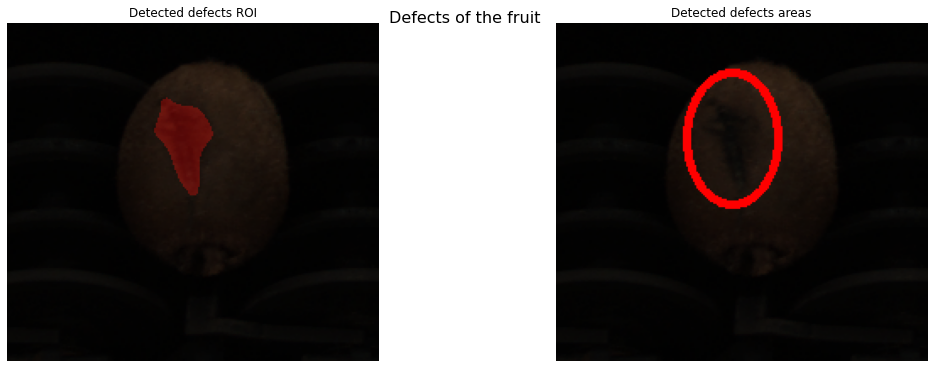

In [60]:
_ = analyze_fruit(colour_darker_images[1], filtered_darker_images[1], tweak_factor=TWEAK_FACTOR, sigma=SIGMA,
                   threshold_1=15, threshold_2=40, mean=mean_final_challege, inv_cov=inv_cov_final_challege)

In [37]:

contours = []

for m in masks:
    c, _ = cv.findContours(m, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours.append(c)

#plt.imshow(edge_masks[0], cmap='gray', vmin=0, vmax=255)
#plt.imshow(cv.cvtColor(c_imgs[0], cv.COLOR_BGR2RGB))
#plt.show()

#contours = [cv.findContours(m, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)[1] for m in edge_masks]

#contours = [c.astype(np.int64) for c in contours]

#print(contours[0].dtype)

In [38]:
contoured_images = [np.copy(img) for img in colour_imgs]

In [39]:
#cv.drawContours(contoured_images[0], contours[0], -1, (0,255,0), 3)

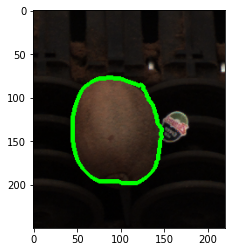

In [40]:
contoured_images = [np.copy(img) for img in colour_imgs]

cv.drawContours(contoured_images[0], contours[0], -1, (0,255,0), 3)

plt.imshow(cv.cvtColor(contoured_images[0], cv.COLOR_BGR2RGB))
plt.show()

In [41]:
max_contours = [sorted(c, key=cv.contourArea)[-1] for c in contours]

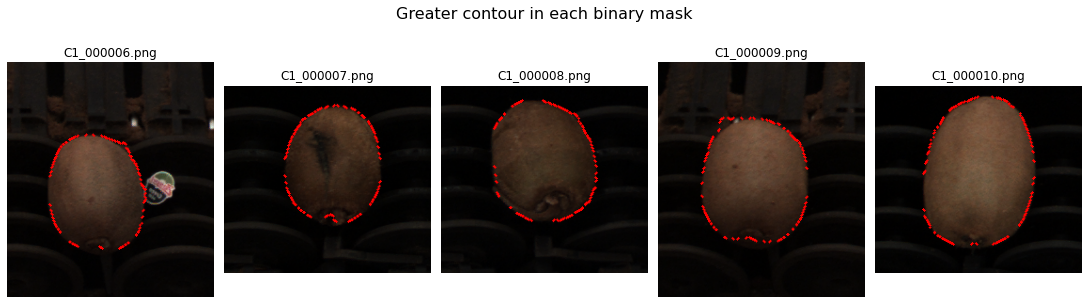

In [42]:
contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, max_contours):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')

In [43]:
def smooth(contour):
    k = 15
    c = cv.copyMakeBorder(contour,  (k-1) // 2, (k-1) // 2 ,0, 0, cv.BORDER_WRAP);
    return cv.blur(c, (1,k),(-1,-1));

cs = [smooth(c) for c in max_contours]

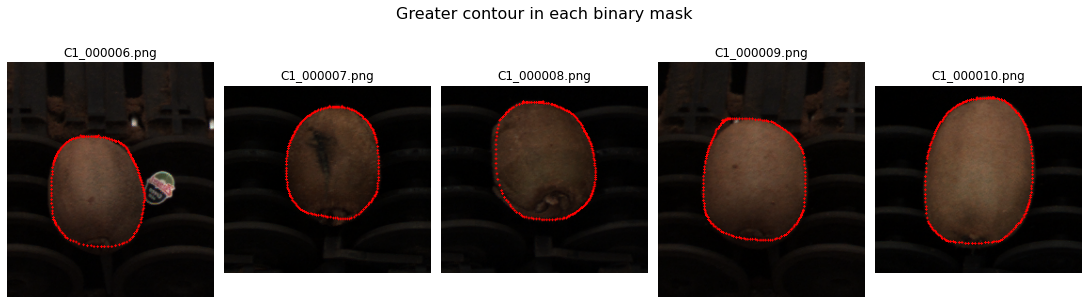

In [44]:
contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, cs):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')

In [45]:
contoured_images = [np.copy(img) for img in colour_imgs]

rect = cv.minAreaRect(contours[0])
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(contoured_images[0], [box], 0,(0,0,255),2)

plt.imshow(cv.cvtColor(contoured_images[0], cv.COLOR_BGR2RGB))
plt.show()

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'minAreaRect'
> Overload resolution failed:
>  - points is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'points'


In [ ]:
'''smoothened = [cv.approxPolyDP(s, .5, True) for s in max_contours]'''


In [ ]:
'''contoured_images = [np.copy(img) for img in colour_imgs]

for img, c in zip(contoured_images, smoothened):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')''';

In [ ]:
'''def get_convexity_points(contour):
    #contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contour = contours[0]

    hull = cv2.convexHull(contour, returnPoints=False)

    points = []

    defects = cv2.convexityDefects(contour, hull)

    if defects is None:
        return points

    for i in range(defects.shape[0]):
        _, _, index, _ = defects[i, 0]
        point = tuple(contour[index][0])
        points.append(point)

    return np.array([points])''';

In [ ]:
'''conv_points = [get_convexity_points(c) for c in cs]


contoured_images = [np.copy(img) for img in colour_imgs]
print()
for img, c in zip(contoured_images, conv_points):
    cv.drawContours(img, c, -1, (0,0,255), 2)

plot_image_grid(contoured_images, colour_names, 'Greater contour in each binary mask')''';

In [ ]:
'''convex_hulls = [cv.convexHull(c, returnPoints=False) for c in max_contours]
defects = [cv.convexityDefects(c, h) for c, h in zip(max_contours, convex_hulls)]''';

In [ ]:
'''for im, h in zip(colour_imgs, convex_hulls):
    # create an empty black image
    drawing = np.copy(im)

    # draw contours and hull points
    cv.drawContours(drawing, h, -1, (0, 255,0), 3)
    plt.imshow(cv.cvtColor(drawing, cv.COLOR_BGR2RGB))
    plt.show()
''';

In [ ]:
print(len(defects))

In [ ]:
print(defects[0][0])

In [ ]:
def ed2(lhs, rhs):
    return(lhs[0] - rhs[0])*(lhs[0] - rhs[0]) + (lhs[1] - rhs[1])*(lhs[1] - rhs[1])


def remove_from_contour(contour, defectsIdx, tmp):
    minDist = sys.maxsize
    startIdx, endIdx = 0, 0

    for i in range(0,len(defectsIdx)):
        for j in range(i+1, len(defectsIdx)):
            dist = ed2(contour[defectsIdx[i]][0], contour[defectsIdx[j]][0])
            if minDist > dist:
                minDist = dist
                startIdx = defectsIdx[i]
                endIdx = defectsIdx[j]

    if startIdx <= endIdx:
        inside = contour[startIdx:endIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:startIdx]
        outside2 = contour[endIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len2 < len1:
            startIdx,endIdx = endIdx,startIdx     
    else:
        inside = contour[endIdx:startIdx]
        len1 = 0 if inside.size == 0 else cv2.arcLength(inside, False)
        outside1 = contour[0:endIdx]
        outside2 = contour[startIdx:len(contour)]
        len2 = (0 if outside1.size == 0 else cv2.arcLength(outside1, False)) + (0 if outside2.size == 0 else cv2.arcLength(outside2, False))
        if len1 < len2:
            startIdx,endIdx = endIdx,startIdx

    if startIdx <= endIdx:
        out = np.concatenate((contour[0:startIdx], contour[endIdx:len(contour)]), axis=0)
    else:
        out = contour[endIdx:startIdx]
    return out


def remove_defects(mask, debug=False):
    tmp = mask.copy()
    #mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # get contour
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    assert len(contours) > 0, "No contours found"
    contour = sorted(contours, key=cv2.contourArea)[-1] #largest contour
    if debug:
        init = cv2.drawContours(tmp.copy(), [contour], 0, (255, 0, 255), 1, cv2.LINE_AA)
        figure, ax = plt.subplots(1)
        ax.imshow(init)
        ax.set_title("Initital Contour")

    hull = cv2.convexHull(contour, returnPoints=False)
    defects = cv2.convexityDefects(contour, hull)

    while True:
        defectsIdx = []
        
        for i in range(defects.shape[0]):
            s, e, f, d = defects[i, 0]
            start = tuple(contour[s][0])
            end = tuple(contour[e][0])
            far = tuple(contour[f][0])
            
            depth = d / 255
            #print(depth)
            if depth > 5:
                defectsIdx.append(f)

        if len(defectsIdx) < 2:
            break

        contour = remove_from_contour(contour, defectsIdx, tmp)
        hull = cv2.convexHull(contour, returnPoints=False)
        defects = cv2.convexityDefects(contour, hull)

    if debug:
      rslt = cv2.drawContours(tmp.copy(), [contour], 0, (0, 0, 255), 2)
      figure, ax = plt.subplots(1)
      ax.imshow(rslt)
      ax.set_title("Corrected Contour")

In [ ]:
cv2 = cv

In [ ]:
remove_defects(masks[3], debug=True)